## Load libraries

In [1]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing the Python code
%autoreload 2

In [2]:
# ml magic
from fastai.tabular import *

# dataviz
import seaborn as sns
sns.set(color_codes=True, rc={'figure.figsize':(12, 4)})
sns.set_palette(sns.color_palette('muted'))

# time wrangling
import matplotlib.dates as mdates
import datetime

## Helper functions

In [3]:
def plot_time_series(df):
    # create subplots
    axes = df.plot(marker='.', ms=2, alpha=0.3, linestyle='None', figsize=(11, 9), subplots=True)
    # loop over subplots and add y label
    for ax in axes:
        ax.set_ylabel('Measured Value')

In [4]:
def process_timestamp(df, col):
    # convert data type
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')
    # set timestamp as index
    df.set_index(col, inplace=True)
    df.sort_index(inplace=True)

## Load and explore the data
Let's load the Aare dataset and take a peek at the first few values in each DataFrame:

In [5]:
DATA = Path('../data/')
!ls {DATA}

external  interim   processed raw


In [6]:
INTERIM = DATA/'interim/'
!ls {INTERIM}

aare_clean.csv            aare_hourly_2009-2014.csv


In [7]:
RAW = Path('../data/raw/')
!ls {RAW}

2017-03-29


In [8]:
RAW_2017 = RAW/'2017-03-29/'
!ls {RAW_2017}

Icon?                aare_as_csv.csv      opendata.csv.zip
_readme.txt          hydro_value_thun.csv
aare.csv             opendata.csv


In [9]:
aare_df = pd.read_csv(RAW_2017/'aare.csv', sep=';'); aare_df.head()

date  temperature  flow  height
0  2009-07-08 18:50:00         17.4   NaN     NaN
1  2009-07-08 19:10:00         17.4   NaN     NaN
2  2009-07-08 19:20:00         17.4   NaN     NaN
3  2009-07-08 19:40:00         17.4   NaN     NaN
4  2009-07-08 19:50:00         17.4   NaN     NaN

## Data preprocessing

### Convert timestamps to datetime

In [10]:
# convert data type
aare_df['date'] = pd.to_datetime(aare_df['date'], format='%Y-%m-%d %H:%M:%S')
# set timestamp as index
aare_df.set_index('date', inplace=True)
aare_df.sort_index(inplace=True)

## Outliers

### Temperature
In our exploratory analysis, we observed a few instances where the river temperature dropped below 0C. As I've never heard of the Aare freezing over in winter, this suggests some sort of measurement error. To get a broader view, let's first get a summary of the numerical attributes:

In [11]:
aare_df.describe()

temperature           flow         height
count  345551.000000  340696.000000  340696.000000
mean       11.473565     119.541568     501.313610
std         4.846541      75.297462      20.135743
min        -9.500000       0.000000       0.000000
25%         6.850000      61.310000     501.700000
50%        11.180000      96.880000     502.010000
75%        15.800000     161.040000     502.470000
max        23.080000     509.660000     504.280000

The maximum value for the temperature looks reasonable, but the minimum is clearly bogus! Let's look at the distribution of values:

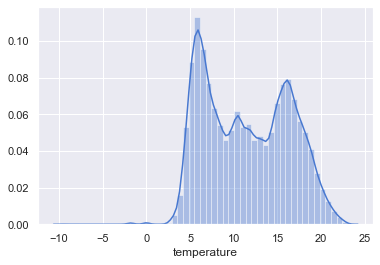

In [12]:
sns.distplot(aare_df['temperature']);

We see the distribution is _multi-modal_ which is what one expects with seasonal data - in this case the distinction between summer and winter. Let's see what percentage of entries are below 2C, which seems to be around the minimum of recorded values by [aaremarzili](https://aaremarzili.info/):

In [13]:
len(aare_df.query('temperature < 2')) / len(aare_df) * 100

0.13890858368229292

OK, only 1.4% of the data involves these spurious values so let's replace them with NaN and interpolate them later:

In [14]:
aare_df.loc[aare_df['temperature'] < 2, 'temperature'] = np.nan

In [15]:
# sanity check
len(aare_df.query('temperature < 2')) / len(aare_df) * 100

0.0

### Flow
Similar to the temperature case, we see that there minimum flow rate is listed as 0 which seems unlikely and is not visible in the plots from aaremarzili.info. Let's see what fraction of events are of this kind:

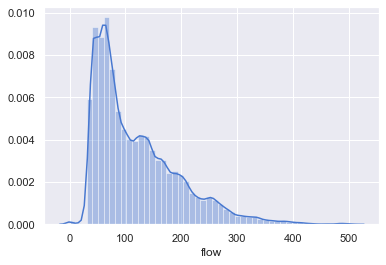

In [16]:
# flow has ~2% missing values so drop for now 
sns.distplot(aare_df['flow'].dropna());

In [17]:
len(aare_df.query('flow == 0')) / len(aare_df) * 100

0.16061304988265118

OK 16% is not an insiginificant amount. Let's replace them with NaN and interpolate later:

In [18]:
aare_df.loc[aare_df['flow'] == 0, 'flow'] = np.nan

# sanity check
len(aare_df.query('flow == 0')) / len(aare_df) * 100

0.0

### Height
Similarly for height, one does not expect the Aare is less than a few metres deep - this is borne out by inspecting the aaremarzili.info website. From the disitribution

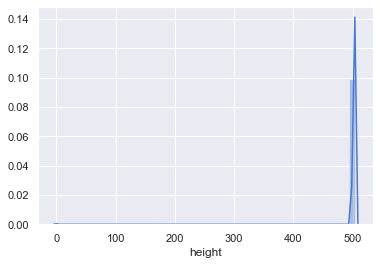

In [19]:
# height has ~2% missing values so drop for now 
sns.distplot(aare_df['height'].dropna());

we see that there are clearly some outliers. Let's see how many events are below 400 cm in height:

In [20]:
len(aare_df.query('height < 400')) / len(aare_df) * 100

0.1594554783519654

Similar to the flow fraction ... perhaps they are connected? In any case, let's replace them with NaN for now:

In [21]:
aare_df.loc[aare_df['height'] < 400, 'height'] = np.nan

# sanity check
len(aare_df.query('height < 400')) / len(aare_df) * 100

0.0

In [22]:
# final sanity check
aare_df.describe()

temperature           flow         height
count  345071.000000  340141.000000  340145.000000
mean       11.491040     119.736621     502.123224
std         4.826752      75.203749       0.525368
min         2.620000      16.000000     499.120000
25%         6.860000      61.430000     501.700000
50%        11.200000      97.040000     502.010000
75%        15.800000     161.150000     502.470000
max        23.080000     509.660000     504.280000

The min / max values now seem to be bounded in reasonable ranges. As a final sanity check, let's plot them:

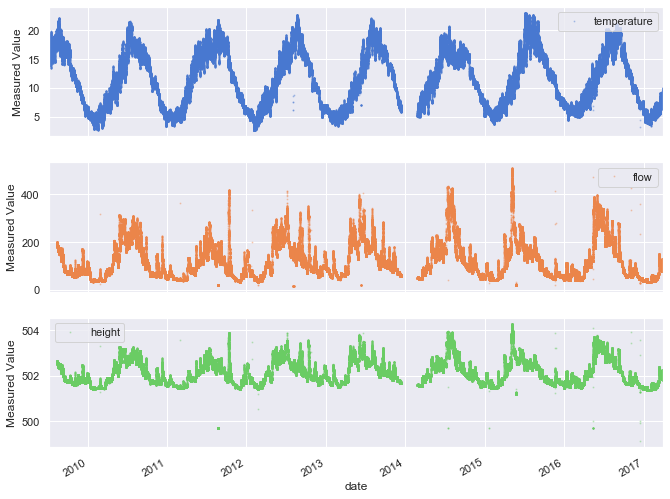

In [23]:
plot_time_series(aare_df)

Cool! We've recovered a periodic signal in the `height` values which we couldn't see before in our exploratory analysis. This seems like a good point to save our state for later use.

In [203]:
aare_df.to_csv(INTERIM/'aare_clean.csv')

## Resampling
Currently our timestamps are spaced in intervals of 10 minutes but useful forecasts are likely not required at that resolution. To smooth out the noise in the data, let's resample to hourly intervals and fill in the missing values:

In [24]:
aare_df = pd.read_csv(INTERIM/'aare_clean.csv'); aare_df.head(1)

date  temperature  flow  height
0  2009-07-08 18:50:00         17.4   NaN     NaN

In [25]:
process_timestamp(aare_df, 'date'); aare_df.head()

temperature  flow  height
date                                          
2009-07-08 18:50:00         17.4   NaN     NaN
2009-07-08 19:10:00         17.4   NaN     NaN
2009-07-08 19:20:00         17.4   NaN     NaN
2009-07-08 19:40:00         17.4   NaN     NaN
2009-07-08 19:50:00         17.4   NaN     NaN

In [26]:
resample_df = aare_df.resample('1H').ffill(); resample_df.head()

temperature  flow  height
date                                          
2009-07-08 18:00:00          NaN   NaN     NaN
2009-07-08 19:00:00         17.4   NaN     NaN
2009-07-08 20:00:00         17.4   NaN     NaN
2009-07-08 21:00:00         17.3   NaN     NaN
2009-07-08 22:00:00         17.1   NaN     NaN

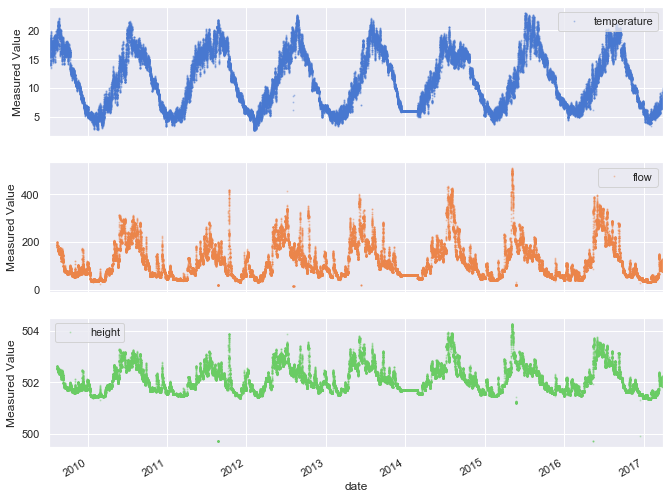

In [27]:
plot_time_series(resample_df)

Given the data hole, one solution for now is to simply focus on the previous time range and (potentially) use the remaining data as a test set.

In [39]:
resample_subset_df = resample_df.copy()[:'2013-11']
resample_subset_df.tail()

temperature   flow  height
date                                           
2013-11-30 19:00:00         7.79  72.65  501.82
2013-11-30 20:00:00         7.74  72.65  501.82
2013-11-30 21:00:00         7.68  72.54  501.82
2013-11-30 22:00:00         7.61  72.44  501.82
2013-11-30 23:00:00         7.55  72.22  501.81

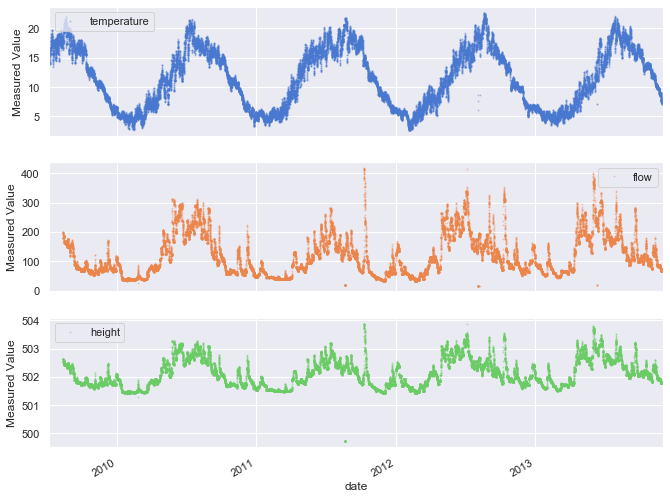

In [40]:
plot_time_series(resample_subset_df)

In [41]:
resample_subset_df.to_csv(INTERIM/'aare_hourly_2009-2013.csv')